In [1]:
import os
import glob
import subprocess
import pandas as pd
import geopandas as gpd
import dask
from matplotlib import pyplot as plt
import rasterio
from dask.distributed import Client, progress, LocalCluster
from pyFIRS.wrappers import lastools
from pyFIRS.utils import fname

In [2]:
# where the imported lidar data is currently stored
WORKDIR = os.path.abspath('/storage/lidar/siskiyou_2017')

# the coordinate reference system we'll be working with
TARGET_EPSG = 6339  # utm 10N, NAD83_2011
# TARGET_EPSG = 6340  # utm 11N, NAD83_2011

Launch a parallel computing cluster. 

In [4]:
cluster = LocalCluster(scheduler_port=7001, dashboard_address=7002)
c = Client(cluster)
num_cores = len(c.ncores())  # identify how many workers we have

At this point, you should also be able to view an interactive dashboard on port 7002. If you're executing this on a remote server, you'll need to set up port forward so you can view the dashboard on your local machine's browser. Once you've done that, or if you're processing on your own machine, you can view the dashboard at [http://localhost:7002/status](http://localhost:7002/status).

In [5]:
las = lastools.useLAStools('/storage/lidar/LAStools/bin')

In [6]:
# define data handling directories
INTERIM = os.path.join(WORKDIR, 'interim')
PROCESSED = os.path.join(WORKDIR,'processed')

In [7]:
# push stuff to the workers on the cluster
c.scatter([INTERIM, PROCESSED, las, TARGET_EPSG, num_cores], broadcast=True);

In [8]:
tiles_to_merge = [fname(tile) for tile in
                  glob.glob(os.path.join(PROCESSED, 'points', '*.laz'))]

print('Found {:,d} tiles to merge derivative products from.'.format(
    len(tiles_to_merge)))

Found 643 tiles to merge derivative products from.


# Merge tiled derivative outputs together
Merge all the tiled GeoTiffs and Shapefiles into single overview files.

We'll produce a shapefile showing the layout of the non-buffered tiles as a single shapefile. This is a single process that takes a few seconds to run, so no need to distribute it using `dask`.

In [9]:
@dask.delayed
def tile_boundaries(*args, **kwargs):
    infiles_path = os.path.join(PROCESSED, 'points', '*.laz')
    OUTFILE = os.path.join(PROCESSED, 'vectors', 'tiles.shp')

    if os.path.exists(OUTFILE):
        pass
    else:
        proc = las.lasboundary(i=infiles_path,
                               use_bb=True,  # use bounding box of tiles
                               overview=True,
                               labels=True,
                               cores=num_cores,  # use parallel processing
                               oshp=True,
                               o=OUTFILE)
    return 'tile_boundaries'

In [10]:
@dask.delayed
def make_footprint(*args, **kwargs):
    if os.path.exists(os.path.join(PROCESSED, 'vectors', 'footprint.shp')):
        pass
    else:
        gdf = gpd.read_file(os.path.join(PROCESSED, 'vectors', 'tiles.shp'))
        gdf['mil_points'] = gdf['num_points'] / 1000000.
        buffered = gdf.drop(['file_name',
                             'point_size',
                             'point_type',
                             'num_points'],
                            axis=1)

        buffered.geometry = gdf.buffer(0.01)  # buffer by 1cm
        union = gpd.GeoDataFrame(geometry=[buffered.unary_union],
                                 crs=buffered.crs)
        union['footprint_id'] = union.index + 1

        buffered = gpd.tools.sjoin(buffered,
                                   union,
                                   how='left').drop('index_right', axis=1)

        aggfuncs = {'mil_points': 'sum',
                    'version': 'first',
                    'min_x': 'min',
                    'min_y': 'min',
                    'min_z': 'min',
                    'max_x': 'max',
                    'max_y': 'max',
                    'max_z': 'max'}

        dissolved = buffered.dissolve(by='footprint_id', aggfunc=aggfuncs)
        OUTFILE = os.path.join(PROCESSED, 'vectors', 'footprint.shp')
        dissolved.to_file(OUTFILE)

        return 'footprint'

Merge the bare earth tiles into a single GeoTiff.

In [12]:
@dask.delayed
def merge_dem(*args, **kwargs):
    infiles = glob.glob(
        os.path.join(PROCESSED, 'rasters', 'dem_tiles', '*.tif'))
    OUTFILE = os.path.join(PROCESSED, 'rasters', 'dem.tif')

    if os.path.exists(OUTFILE):
        pass

    elif len(infiles) < 500:
        return subprocess.run(['rio', 'merge',
                               *infiles,
                               OUTFILE,
                               '--co', 'compress=LZW',
                               '--co', 'tiled=true',
                               '--co', 'blockxsize=256',
                               '--co', 'blockysize=256',
                               '--co', 'bigtiff=YES'],
                              stderr=subprocess.PIPE,
                              stdout=subprocess.PIPE)
    else:
        merge_chunks(infiles, OUTFILE)

    return 'dem'

In [ ]:
@dask.delayed
def vrt_then_tif(infiles, vrtfile, outfile):
    """Mosaics files into a single GeoTiff
    
    Parameters
    ----------
    infiles : list
      list of paths to input files to mosaic
    vrtfile : str, path to file
      path to VRT file that will be created
    outfile : str, path to file
      output GeoTiff that will be created
    
    Returns
    --------
    proc1, proc2 : CompletedProcess
      the result of executing gdalbuildvrt and gdal_translate 
      using subprocess
    """
    proc1 = subprocess.run(['gdalbuildvrt',
                                VRTFILE,
                                *infiles],
                               stderr=subprocess.PIPE,
                               stdout=subprocess.PIPE)
    proc2 = subprocess.run(['gdal_translate',
                            '-of', 'GTiff',
                            '-co', 'compress=LZW',
                            '-co', 'tiled=true',
                            '-co', 'blockxsize=256',
                            '-co', 'blockysize=256',
                            '-co', 'bigtiff=YES']
                           VRTFILE,
                           OUTFILE],
                           stderr=subprocess.PIPE,
                           stdout=subprocess.PIPE)

In [13]:
@dask.delayed
def merge_intensity(*args, **kwargs):
    infiles = glob.glob(
        os.path.join(PROCESSED, 'rasters', 'intensity_tiles', '*.tif'))
    VRTFILE = os.path.join(PROCESSED, 'rasters', 'intensity_tiles', 'intensity.vrt')
    OUTFILE = os.path.join(PROCESSED, 'rasters', 'intensity.tif')

    if os.path.exists(OUTFILE):
        pass

    else:
        procs = vrt_then_tif(infiles, VRTFILE, OUTFILE)

    return 'intensity'

Now merge the hillshade tiles into a single raster formatted as GeoTiff.

In [14]:
@dask.delayed
def merge_hillshade(*args, **kwargs):
    infiles = glob.glob(
        os.path.join(PROCESSED, 'rasters', 'hillshade_tiles', '*.tif'))
    VRTFILE = os.path.join(PROCESSED, 'rasters', 'hillshade_tiles', 'hillshade.vrt')
    OUTFILE = os.path.join(PROCESSED, 'rasters', 'hillshade.tif')

    if os.path.exists(OUTFILE):
        pass

    else:
        procs = vrt_then_tif(infiles, VRTFILE, OUTFILE)

    return 'hillshade'

Merge the trimmed canopy height model tiles into a single raster.

In [15]:
@dask.delayed
def merge_chm(*args, **kwargs):
    infiles = glob.glob(
        os.path.join(PROCESSED, 'rasters', 'chm_tiles', '*.tif'))
    VRTFILE = os.path.join(PROCESSED, 'rasters', 'chm_tiles', 'chm.vrt'))
    OUTFILE = os.path.join(PROCESSED, 'rasters', 'chm.tif')

    if os.path.exists(OUTFILE):
        pass

    else:
        procs = vrt_then_tif(infiles, VRTFILE, OUTFILE)

    return 'chm'

Merge the cleaned tiles of building footprints together into a single shapefile. We'll use `geopandas` to concatenate all the polygons together into a single geodataframe and then write out to a new shapefile.

In [16]:
@dask.delayed
def merge_bldgs(*args, **kwargs):
    infiles = glob.glob(
        os.path.join(PROCESSED, 'vectors', 'building_tiles', '*.shp'))
    OUTFILE = os.path.join(PROCESSED, 'vectors', 'buildings.shp')

    if os.path.exists(OUTFILE):
        pass
    else:
        # list of geodataframes with tiles of building footprints
        gdflist = [gpd.read_file(tile) for tile in infiles]
        # merge them all together
        merged = pd.concat(gdflist, ignore_index=True)
        # add projection information back in
        merged.crs = gdflist[0].crs
        # and write the merged data to a new shapefile
        merged.to_file(OUTFILE)

    return 'bldgs'

In [17]:
@dask.delayed
def merge_highpoints(*args, **kwargs):
    infiles = glob.glob(
        os.path.join(INTERIM, 'chm_tiles', 'treesegs', '*HighPoints.shp'))
    OUTFILE = os.path.join(PROCESSED, 'vectors', 'high_points.shp')

    if os.path.exists(OUTFILE):
        pass
    else:
        # list of geodataframes with tiles of building footprints
        gdflist = [gpd.read_file(tile) for tile in infiles]
        # merge them all together
        merged = pd.concat(gdflist, ignore_index=True)
        # add projection information back in
        merged.crs = gdflist[0].crs
        # and write the merged data to a new shapefile
        merged.to_file(OUTFILE)

    return 'highpoints'

In [18]:
@dask.delayed
def merge_crowns(*args, **kwargs):
    infiles = glob.glob(
        os.path.join(INTERIM, 'chm_tiles', 'treesegs', '*Polygons.shp'))
    OUTFILE = os.path.join(PROCESSED, 'vectors', 'tree_crowns.shp')

    if os.path.exists(OUTFILE):
        pass
    else:
        # list of geodataframes with tiles of building footprints
        gdflist = [gpd.read_file(tile) for tile in infiles]
        # merge them all together
        merged = gpd.GeoDataFrame(pd.concat(gdflist, ignore_index=True))
        # add projection information back in
        merged.crs = gdflist[0].crs
        # and write the merged data to a new shapefile
        merged.to_file(OUTFILE)

    return 'crowns'

In [19]:
all_grid_tiles_paths = glob.glob(
    os.path.join(PROCESSED, 'rasters',
                 'gridmetrics_tiles', '*_strat0_intensity-median.tif'))

all_grid_tiles = [fname(tile).split('_strat0_intensity-median')[0] for
                  tile in all_grid_tiles_paths]

example_tile = os.path.basename(
    all_grid_tiles_paths[0]).split('_strat0_intensity-median.tif')[0]

grid_rasters = [os.path.basename(file).split(example_tile)[-1][1:-4] for
                file in glob.glob(
                    os.path.join(PROCESSED, 'rasters',
                                 'gridmetrics_tiles', example_tile + '*.tif'))]

print('{:d} different types of rasters from gridmetrics '
      'to process for each tile:\r\n'.format(len(grid_rasters)))

for i, raster in enumerate(grid_rasters):
    print('{}.  {}'.format(i+1, raster))

29 different types of rasters from gridmetrics to process for each tile:

1.  strat0_return-proportion
2.  strat1_return-proportion
3.  strat2_return-proportion
4.  strat3_return-proportion
5.  strat4_return-proportion
6.  strat5_return-proportion
7.  strat0_intensity-median
8.  strat1_intensity-median
9.  strat2_intensity-median
10.  strat3_intensity-median
11.  strat4_intensity-median
12.  strat5_intensity-median
13.  elevation
14.  slope
15.  aspect
16.  profile_curvature
17.  plan_curvature
18.  solar_radiation_index
19.  overall_curvature
20.  height_max
21.  height_05-percentile
22.  height_25-percentile
23.  height_50-percentile
24.  height_75-percentile
25.  height_95_percentile
26.  cover
27.  num_returns
28.  skewness
29.  kurtosis


In [20]:
all_gridsurf_tiles_paths = glob.glob(
    os.path.join(PROCESSED, 'rasters',
                 'gridsurface_tiles', '*_potential_volume.tif'))

all_gridsurf_tiles = [fname(tile).split('_strat0_intensity-median')[0] for
                      tile in all_gridsurf_tiles_paths]

example_tile = os.path.basename(
    all_gridsurf_tiles_paths[0]).split('_potential_volume.tif')[0]

gridsurf_rasters = [os.path.basename(file).split(example_tile)[-1][1:-4] for
                    file in glob.glob(
                        os.path.join(PROCESSED, 'rasters',
                                     'gridsurface_tiles',
                                     example_tile + '*.tif'))]

# we don't want these redundant rasters
gridsurf_rasters = [x for x in gridsurf_rasters if x not
                    in ['mean_height', 'max_height']]

print('{:d} different types of rasters from gridsurface '
      'to process for each tile:\r\n'.format(len(gridsurf_rasters)))
for i, raster in enumerate(gridsurf_rasters):
    print('{}.  {}'.format(i+1, raster))

5 different types of rasters from gridsurface to process for each tile:

1.  stddev_height
2.  surface_area_ratio
3.  potential_volume
4.  surface_volume
5.  surface_volume_ratio


In [21]:
# @dask.delayed
def merge_gridmetric(metric):
    infiles = glob.glob(
        os.path.join(PROCESSED, 'rasters',
                     'gridmetrics_tiles', '*{}*.tif'.format(metric)))
    VRTFILE = os.path.join(PROCESSED, 'rasters',
                           'gridmetrics_tiles', '*{}*.vrt'.format(metric)))
    OUTFILE = os.path.join(PROCESSED, 'rasters', '{}.tif'.format(metric))

    if os.path.exists(OUTFILE):
        pass

    else:
        procs = vrt_then_tif(infiles, VRTFILE, OUTFILE)

    return metric

In [22]:
# @dask.delayed
def merge_gridsurface(metric):
    infiles = glob.glob(
        os.path.join(PROCESSED, 'rasters',
                     'gridsurface_tiles', '*{}.tif'.format(metric)))
    VRTFILE = os.path.join(PROCESSED, 'rasters',
                           'gridsurface_tiles', '*{}.vrt'.format(metric)))
    OUTFILE = os.path.join(PROCESSED, 'rasters',
                           '{}.tif'.format(metric))

    if os.path.exists(OUTFILE):
        pass

    else:
        procs = vrt_then_tif(infiles, VRTFILE, OUTFILE)

    return metric

A single state that will depend upon the completion of the merged rasters and vectors.

In [23]:
@dask.delayed
def merge_done(*args, **kwargs):
    return

In [24]:
# building the computation receipe
merge_dsk = {}
merge_dsk['tile_boundaries'] = (tile_boundaries,)
merge_dsk['footprint'] = (make_footprint, 'tile_boundaries')
merge_dsk['merge_bldgs'] = (merge_bldgs,)
merge_dsk['merge_hill'] = (merge_hillshade,)
merge_dsk['merge_dem'] = (merge_dem,)
merge_dsk['merge_intensity'] = (merge_intensity,)
merge_dsk['merge_chm'] = (merge_chm,)
for raster in grid_rasters:
    merge_dsk['merge_gridmetric-{}'.format(raster)] = (merge_gridmetric,
                                                       raster)
for raster in gridsurf_rasters:
    merge_dsk['merge_gridsurface-{}'.format(raster)] = (merge_gridsurface,
                                                        raster)

merge_dsk['merge_done'] = (merge_done,
                           ['tile_boundaries', 'footprint']+ #) # +
                           ['merge_bldgs'] + #)
                           ['merge_hill', 'merge_dem'] +
                           ['merge_chm', 'merge_intensity'] +
                           ['merge_gridmetric-{}'.format(raster) for
                            raster in grid_rasters] +
                           ['merge_gridsurface-{}'.format(raster) for
                            raster in gridsurf_rasters])

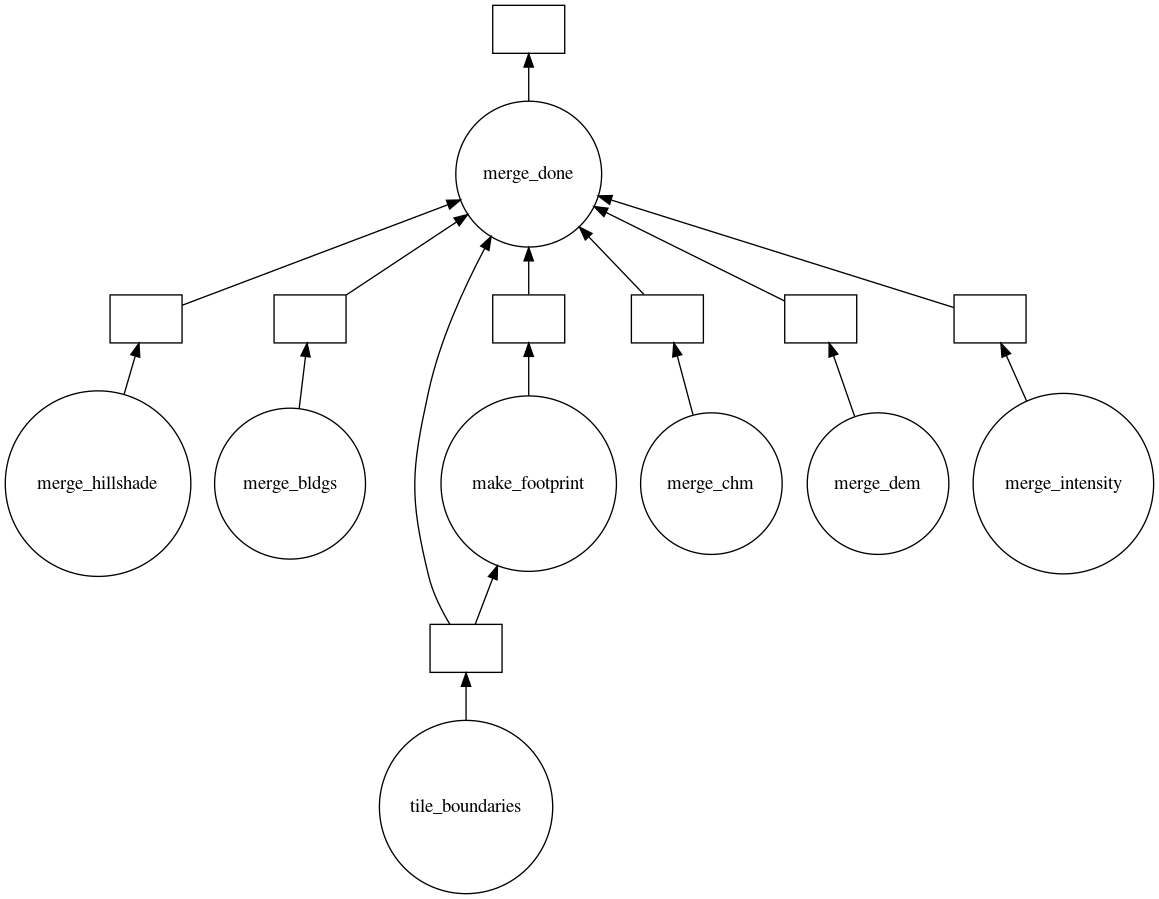

In [25]:
merge_graph = c.get(merge_dsk, 'merge_done')  # build the computation graph
merge_graph.visualize()

In [26]:
merge_results = c.persist(merge_graph) # this might take a while...

In [27]:
progress(merge_results)

VBox()

In [ ]:
# merge_results.result()

In [ ]:
c.cancel(merge_results)

In [ ]:
c.close()
cluster.close()

In [ ]:
for raster in grid_rasters:
    merge_gridmetric(raster)
    print(raster)
print('Done.')

In [ ]:
for raster in gridsurf_rasters:
    merge_gridsurface(raster)
    print(raster)
print('Done.')